# Benchmarking Results from Classification and Regression

#### Set Up

In [1]:
%pip install pandas_ta_classic
%pip install --upgrade pandas_ta_classic
%pip install pyarrow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import site
import os

# Find the path to the pandas_ta_classic library and patch it
pandas_ta_classic_path = None
for sp in site.getsitepackages():
    pandas_ta_classic_path = os.path.join(sp, 'pandas_ta_classic')
    if os.path.exists(pandas_ta_classic_path):
        break

if pandas_ta_classic_path:
    squeeze_pro_path = os.path.join(pandas_ta_classic_path, 'momentum', 'squeeze_pro.py')
    if os.path.exists(squeeze_pro_path):
        try:
            with open(squeeze_pro_path, 'r') as f:
                lines = f.readlines()

            new_lines = []
            fixed = False
            for line in lines:
                if "from numpy import NaN as npNaN" in line:
                    new_lines.append(line.replace("from numpy import NaN as npNaN", "# from numpy import NaN as npNaN\nimport numpy as np\n"))
                    fixed = True
                    print("Modified import statement in squeeze_pro.py")
                else:
                    new_lines.append(line)

            if fixed:
                with open(squeeze_pro_path, 'w') as f:
                    f.writelines(new_lines)
                print("Successfully patched pandas_ta_classic/momentum/squeeze_pro.py")
            else:
                print("Could not find the problematic import line in squeeze_pro.py")

        except Exception as e:
            print(f"Error modifying squeeze_pro.py: {e}")
    else:
        print(f"Could not find squeeze_pro.py at {squeeze_pro_path}")
else:
    print("Could not find the pandas_ta_classic library installation path.")

import pandas_ta_classic as ta

Could not find the problematic import line in squeeze_pro.py


In [3]:
%pip install torch
%pip install scikit-learn
%pip install torchvision

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import (
    precision_score, recall_score, f1_score, matthews_corrcoef,
    mean_squared_error, mean_absolute_error, r2_score, confusion_matrix,
    ConfusionMatrixDisplay
)

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from contextlib import nullcontext

import scipy

import random

import matplotlib.pyplot as plt

from unicodedata import bidirectional


#### Confusion Matrix 

In [5]:
def compute_confusion(y_true, y_pred, labels=None, normalize=None):
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize=normalize)
    return cm

def plot_confusion(cm, labels, title="Confusion Matrix"):
    fig, ax = plt.subplots(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax, values_format=".2f" if cm.dtype.kind=='f' else "d", cmap='Blues', colorbar=False)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()
    
def pct_str(x, decimals=1):
    return f"{x*100:.{decimals}f}%"    
    
def edge_labels_from_edges(edges, decimals=1):
    """
    Turn monotonic edges (len = C+1) into C human-readable labels, e.g.
    [-0.023, -0.006, 0.001, 0.008] -> ["≤ -2.3%", "(-2.3%,-0.6%]", "(-0.6%,0.1%]"]
    Uses left-closed, right-open for inner, with pretty endpoints.
    """
    C = len(edges) - 1
    labels = []
    for i in range(C):
        lo, hi = edges[i], edges[i+1]
        if i == 0:
            labels.append(f"≤ {pct_str(hi, decimals)}")
        elif i == C-1:
            labels.append(f"> {pct_str(lo, decimals)}")
        else:
            labels.append(f"({pct_str(lo, decimals)},{pct_str(hi, decimals)}]")
    return labels
    

def aggregate_confusions_with_median_edges(results_df, n_classes=6):
    """
    Returns:
      agg_cm: (C x C) summed confusion matrix over companies
      q_labels: ['Q1',...,'QC']
      interval_labels: human-friendly labels built from *median* edges across companies
      display_labels: ['Q1 ≤ -0.9%', 'Q2 (-0.9%,-0.2%]', ...]  <- what you’ll plot
    """
    if results_df is None or results_df.empty:
        return None, None, None, None

    # Collect confusion matrices and edges
    cm_list = []
    edges_list = []
    for _, row in results_df.iterrows():
        cm = row.get('confusion_matrix', None)
        edges = row.get('bucket_edges', None)
        if cm is not None:
            cm_list.append(np.array(cm, dtype=float))
        if edges is not None:
            edges_list.append(np.array(edges, dtype=float))

    if not cm_list:
        return None, None, None, None

    # Sum all confusion matrices (same class order 0..C-1)
    agg_cm = np.sum(cm_list, axis=0)

    # If we have edges from multiple companies, compute a *median* edge curve
    if edges_list:
        E = np.stack(edges_list, axis=0)         # shape [N_co, C+1]
        median_edges = np.median(E, axis=0)      # length C+1, monotonic by construction
    else:
        # Fallback: equal-width quantiles for label text (not ideal, but safe)
        median_edges = np.linspace(-0.1, 0.1, n_classes+1)

    # Build human-friendly interval labels from median edges
    interval_labels = edge_labels_from_edges(median_edges, decimals=1)

    # Prefix with Q1..QC to make it obvious they’re quantile buckets
    q_labels = [f"Q{i}" for i in range(1, n_classes+1)]
    display_labels = [f"{q_labels[i]} {interval_labels[i]}" for i in range(n_classes)]

    return agg_cm, q_labels, interval_labels, display_labels


### Utility Classes and Functions

In [6]:
def set_global_seeds(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_global_seeds(42)

# Datasets
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Models
class RNNHead(nn.Module):
    """
    Shared head:
      - RNN stack (LSTM/GRU, uni/bi)
      - BatchNorm + Dense(32, ReLU) + Dropout(0.3)
      - Output layer (1 unit): linear (regression) or logits (classification)
    """
    def __init__(self, input_size, rnn_type='LSTM', bidirectional=False, problem_type='regression', output_dim=1):
        super().__init__()
        hidden1 = 128
        hidden2 = 64
        self.problem_type = problem_type
        self.bidirectional = bidirectional
        self.rnn_type = rnn_type.upper()

        rnn_cls = {'LSTM': nn.LSTM, 'GRU': nn.GRU}[('GRU' if 'GRU' in self.rnn_type else 'LSTM')]

        self.rnn1 = rnn_cls(
            input_size=input_size, hidden_size=hidden1, num_layers=1,
            batch_first=True, dropout=0.0, bidirectional=bidirectional
        )
        
        self.inter_rnn_drop = nn.Dropout(0.1)
        
        self.rnn2 = rnn_cls(
            input_size=hidden1*(2 if bidirectional else 1), hidden_size=hidden2, num_layers=1,
            batch_first=True, dropout=0.0, bidirectional=bidirectional
        )

        feat_dim = hidden2*(2 if bidirectional else 1)

        self.bn = nn.BatchNorm1d(feat_dim)
        self.fc = nn.Linear(feat_dim, 32)
        self.drop = nn.Dropout(0.3)
        self.out = nn.Linear(32, output_dim)

    def forward(self, x):
        # x: [B, T, F]
        out, _ = self.rnn1(x)
        out = self.inter_rnn_drop(out)   # inter-layer dropout (sequence-wise)
        out, _ = self.rnn2(out)
        # take last timestep: [B, T, H] -> [B, H]
        out = out[:, -1, :]
        out = self.bn(out)
        out = F.relu(self.fc(out))
        out = self.drop(out)
        out = self.out(out)  # shape [B, 1] or [B, output_dim]
        return out  # regression: raw; classification: logits

def build_model(input_shape, model_type='LSTM', problem_type='regression'):
    seq_len, n_features = input_shape
    output_dim = 6 if problem_type == 'multiclass' else 1
    model_type = model_type.upper()
    if model_type == 'LSTM':
        return RNNHead(n_features, rnn_type='LSTM', bidirectional=False, problem_type=problem_type, output_dim=output_dim)
    elif model_type == 'BILSTM':
        return RNNHead(n_features, rnn_type='LSTM', bidirectional=True, problem_type=problem_type, output_dim=output_dim)
    elif model_type == 'GRU':
        return RNNHead(n_features, rnn_type='GRU', bidirectional=False, problem_type=problem_type, output_dim=output_dim)
    elif model_type == 'BIGRU':
        return RNNHead(n_features, rnn_type='GRU', bidirectional=True, problem_type=problem_type, output_dim=output_dim)
    else:
        raise ValueError("Model type must be one of: ['LSTM','BiLSTM','GRU','BiGRU']")

# Early Stopping (PyTorch)
class EarlyStopper:
    def __init__(self, patience=15, min_delta=0.0, restore_best=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best = restore_best
        self.best_loss = float('inf')
        self.counter = 0
        self.best_state = None

    def step(self, val_loss, model):
        improved = (self.best_loss - val_loss) > self.min_delta
        if improved:
            self.best_loss = val_loss
            self.counter = 0
            if self.restore_best:
                # Deep copy state dict
                self.best_state = {k: v.detach().clone() for k, v in model.state_dict().items()}
        else:
            self.counter += 1
        return self.counter >= self.patience

    def restore(self, model):
        if self.restore_best and self.best_state is not None:
            model.load_state_dict(self.best_state)
            
def best_threshold_from_val(val_logits, val_labels, metric='mcc'):
    p = 1.0 / (1.0 + np.exp(-val_logits))
    grid = np.linspace(0.2, 0.8, 61)
    best_t, best_s = 0.5, -1.0
    for t in grid:
        yhat = (p >= t).astype(int)
        if metric == 'f1':
            s = f1_score(val_labels, yhat, zero_division=0)
        else:
            s = matthews_corrcoef(val_labels, yhat) if len(np.unique(yhat)) > 1 else -1
        if s > best_s:
            best_s, best_t = s, t
    return best_t


### Bucket Scheme

In [7]:
BUCKET_BINS   = [-float('inf'), -0.15, -0.08, 0.0, 0.08, 0.15, float('inf')]
BUCKET_LABELS = [0, 1, 2, 3, 4, 5]   
BUCKET_LABEL_NAMES = {
    0: "Q1",
    1: "Q2",
    2: "Q3",
    3: "Q4",
    4: "Q5",
    5: "Q6"
}

display_labels = [BUCKET_LABEL_NAMES[i] for i in BUCKET_LABELS]

def pct_return(series, h):
    return series.shift(-h) / series - 1.0

def bucketise_returns(ret_series):
    return pd.cut(ret_series, bins=BUCKET_BINS, labels=BUCKET_LABELS, include_lowest=True, right=True).astype('Int64')

### Bucket Helper Functions

In [8]:
import numpy as np

def safe_quantile_edges(x, n_classes=6):
    qs = np.linspace(0, 1, n_classes+1)
    edges = np.quantile(x, qs)
    for i in range(1, len(edges)):
        if edges[i] <= edges[i-1]:
            edges[i] = np.nextafter(edges[i-1], np.inf)
    return edges  # length n_classes+1

def bucketize_with_edges(x, edges):
    inner = edges[1:-1]
    labels = np.digitize(x, inner, right=True)
    return labels.astype(int)  # 0..C-1


## Stock Prediction Pipeline

In [9]:
class StockPredictionPipeline:
    def __init__(self, df, feature_columns, model_type='LSTM', sequence_length=30, problem_type='regression', horizon_steps=1):
        self.df = df.copy()
        self.feature_columns = feature_columns
        self.model_type = model_type
        self.sequence_length = sequence_length
        self.problem_type = problem_type
        self.horizon_steps = horizon_steps
        self.results = []
        self.loss_curves = []

        # Validate
        self._validate_inputs()

        # Device & precision
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.mixed_precision = torch.cuda.is_available()

        print(f"Pipeline initialized for a '{self.problem_type}' problem "
              f"with horizon {self.horizon_steps} steps. Device: {self.device}")

    def _validate_inputs(self):
        missing_cols = [col for col in self.feature_columns if col not in self.df.columns]
        if missing_cols:
            raise ValueError(f"Missing feature columns: {missing_cols}")

        if 'close' not in self.df.columns and 'close_price' not in self.df.columns:
            raise ValueError("No 'close' or 'close_price' column found in data")

        valid_models = ['LSTM', 'BiLSTM', 'GRU', 'BiGRU']
        if self.model_type not in valid_models:
            raise ValueError(f"Model type must be one of: {valid_models}")

        if self.problem_type not in ['regression', 'classification', 'multiclass']:
            raise ValueError("Problem type must be 'regression', 'classification', or 'multiclass'")

    def create_target_variable(self, company_data):
        company_data = company_data.copy()
        price_col = 'close' if 'close' in company_data.columns else 'close_price'
        if 'date' in company_data.columns:
            company_data = company_data.sort_values('date')
            
        h = self.horizon_steps

        company_data['target_regression'] = (
            np.log(company_data[price_col].shift(-h)) - np.log(company_data[price_col])
        )
        company_data['target_direction'] = (company_data['target_regression'] > 0).astype(int)        

        if self.problem_type == 'regression':
            company_data = company_data.dropna()
        elif self.problem_type == 'classification':
            company_data = company_data.dropna()
        else:
            company_data['ret_h'] = pct_return(company_data[price_col], h)
            subset = ['ret_h']
            company_data = company_data.dropna(subset=subset)        
            
        return company_data

    def create_sequences(self, features, *targets):
        X = []
        y_sequences = [[] for _ in targets]
        for i in range(self.sequence_length, len(features)):
            X.append(features[i-self.sequence_length:i])
            for j, target in enumerate(targets):
                y_sequences[j].append(target[i])
        return (np.array(X),) + tuple(np.array(y) for y in y_sequences)

    def _train_one_epoch(self, model, loader, optimizer, loss_fn, scaler):
        model.train()
        total_loss = 0.0
        for xb, yb in loader:
            xb = xb.to(self.device)
            yb = yb.to(self.device)
            if self.problem_type in ['regression', 'classification']:
                yb = yb.view(-1, 1) #single output heads

            optimizer.zero_grad(set_to_none=True)

            ctx = torch.amp.autocast('cuda') if self.mixed_precision else nullcontext()
            with ctx:
                logits = model(xb)
                if self.problem_type == 'multiclass':
                    loss = loss_fn(logits, yb.long())
                else:
                    loss = loss_fn(logits, yb)

            if self.mixed_precision:
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

            total_loss += loss.item() * xb.size(0)

        return total_loss / len(loader.dataset)

    @torch.no_grad()
    def _eval_one_epoch(self, model, loader, loss_fn):
        model.eval()
        total_loss = 0.0
        for xb, yb in loader:
            xb = xb.to(self.device)
            yb = yb.to(self.device)
            
            if self.problem_type in ['regression', 'classification']:
                yb = yb.view(-1, 1) #single output heads
                
            logits = model(xb)
            if self.problem_type == 'multiclass':
                loss = loss_fn(logits, yb.long())
            else:
                loss = loss_fn(logits, yb)
            total_loss += loss.item() * xb.size(0)
        return total_loss / len(loader.dataset)

    @torch.no_grad()
    def _predict(self, model, loader):
        model.eval()
        outs = []
        for xb, _ in loader:
            xb = xb.to(self.device)
            logits = model(xb).squeeze(1).detach().cpu().numpy()
            outs.append(logits)
        return np.concatenate(outs, axis=0)

    def build_model(self, input_shape):
        model = build_model(input_shape, model_type=self.model_type, problem_type=self.problem_type)
        return model.to(self.device)

    def process_company(self, company_name, company_data, sector):
        print(f"\nProcessing {company_name} ({sector})...")
        try:
            company_data = self.create_target_variable(company_data)

            # Min samples requirement (same heuristic)
            min_samples = self.sequence_length + 150 + self.horizon_steps
            if len(company_data) < min_samples:
                print(f"Insufficient data for {company_name} ({len(company_data)} < {min_samples}). Skipping...")
                return None

            if company_data[self.feature_columns].isnull().any().any():
                print(f"Missing values in features for {company_name}. Skipping...")
                return None

            features = company_data[self.feature_columns].values
            target_reg = company_data['target_regression'].values
            target_dir = company_data['target_direction'].values
            # if self.problem_type == 'multiclass':
            #     target_bucket = company_data['y_bucket'].values

            # Create sequences
            if self.problem_type == 'multiclass':
                X_raw, y_reg, y_dir = self.create_sequences(features, target_reg, target_dir)
            else:
                X_raw, y_reg, y_dir = self.create_sequences(features, target_reg, target_dir)

            # TimeSeriesSplit
            n_splits = min(5, len(X_raw) // 50)
            if n_splits < 3:
                print(f"Insufficient data for proper time series validation for {company_name}. Skipping...")
                return None

            tscv = TimeSeriesSplit(n_splits=n_splits)
            splits = list(tscv.split(X_raw))
            train_idx, test_idx = splits[-1]

            # Train/Val split (last 20% of train for val)
            val_size = int(0.2 * len(train_idx))
            final_train_idx = train_idx[:-val_size]
            val_idx = train_idx[-val_size:]
            
            if self.horizon_steps > 1:
                print("Adjusting for multi-step horizon...")
                gap = self.horizon_steps
                if len(final_train_idx) > gap:
                    final_train_idx = final_train_idx[:-gap]  # drop last h labels from train
                if len(val_idx) > gap:
                    val_idx = val_idx[gap:]  # drop last h labels from val

            X_train_raw, X_val_raw, X_test_raw = X_raw[final_train_idx], X_raw[val_idx], X_raw[test_idx]
            
            F = X_raw.shape[-1]
            feat_scaler = StandardScaler()
            X_train = feat_scaler.fit_transform(X_train_raw.reshape(-1, F)).reshape(X_train_raw.shape)
            X_val   = feat_scaler.transform(X_val_raw.reshape(-1, F)).reshape(X_val_raw.shape)
            X_test  = feat_scaler.transform(X_test_raw.reshape(-1, F)).reshape(X_test_raw.shape)

            if self.problem_type == 'regression':
                y_train, y_val, y_test = y_reg[final_train_idx], y_reg[val_idx], y_reg[test_idx]
                target_scaler = StandardScaler()
                y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
                y_val_scaled   = target_scaler.transform(y_val.reshape(-1, 1)).flatten()
                train_target, val_target = y_train_scaled, y_val_scaled

            elif self.problem_type == 'classification':
                y_train, y_val, y_test = y_dir[final_train_idx], y_dir[val_idx], y_dir[test_idx]
                train_target, val_target = y_train, y_val
                target_scaler = None
                class_ratio = np.mean(y_train)
                if class_ratio < 0.1 or class_ratio > 0.9:
                    print(f"Severe class imbalance for {company_name} ({class_ratio:.3f}). Consider using class weights.")

            elif self.problem_type == 'multiclass':
                #TRAIN only quantile bucketing
                #pull forward returns aligned with raw rows, then align to sequence targets
                if 'ret_h' not in company_data.columns:
                    raise RuntimeError("Expected 'ret_h' for multiclass but it was not found. "
                                       "Ensure create_target_variable sets it for multiclass runs.")
                ret_full = company_data['ret_h'].values                     # length == len(company_data)
                ret_seq_full = ret_full[self.sequence_length:]              # align with sequence targets

                #split-aligned return vectors
                ret_train = ret_seq_full[final_train_idx]
                ret_val   = ret_seq_full[val_idx]
                ret_test  = ret_seq_full[test_idx]

                #learn bucket edges from TRAIN only
                edges = safe_quantile_edges(ret_train, n_classes=6)
                label_names = edge_labels_from_edges(edges, decimals=1)

                #bucketize all splits using those edges
                y_bucket = bucketize_with_edges(ret_seq_full, edges)
                y_train = y_bucket[final_train_idx]
                y_val   = y_bucket[val_idx]
                y_test  = y_bucket[test_idx]

                train_target, val_target = y_train, y_val
                target_scaler = None
            else:
                raise ValueError("Unknown problem type.")
            

            # Datasets & loaders
            if self.problem_type == 'multiclass':
                train_ds = SequenceDataset(X_train, train_target.astype(np.int64))
                val_ds   = SequenceDataset(X_val,   val_target.astype(np.int64))
                test_ds  = SequenceDataset(X_test,  y_test.astype(np.int64))
            else:
                train_ds = SequenceDataset(X_train, train_target)
                val_ds   = SequenceDataset(X_val,   val_target)
                test_ds  = SequenceDataset(X_test,  y_test)

            train_loader = DataLoader(train_ds, batch_size=32, shuffle=False, drop_last=False, num_workers=0)
            val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, drop_last=False, num_workers=0)
            test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, drop_last=False, num_workers=0)

            # Build model
            model = self.build_model((self.sequence_length, len(self.feature_columns)))

            # Loss functions
            if self.problem_type == 'regression':
                loss_fn = nn.HuberLoss(delta=1.0)
            elif self.problem_type == 'classification':
                # Use BCEWithLogitsLoss for numerical stability (logits input)
                loss_fn = nn.BCEWithLogitsLoss()
            elif self.problem_type == 'multiclass':
                # class weights from TRAIN only (handle missing classes)
                counts = np.bincount(train_target, minlength=6).astype(float)
                weights = (counts.sum() / np.maximum(counts, 1.0))
                weights = torch.tensor(weights, dtype=torch.float32, device=self.device)
                loss_fn = nn.CrossEntropyLoss(weight=weights)

            # Optimizer & scheduler
            optimizer = Adam(model.parameters(), lr=1e-3, eps=1e-7, weight_decay=1e-5)
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, min_lr=1e-7)
            early_stopper = EarlyStopper(patience=15, min_delta=0.0, restore_best=True)
            scaler = torch.amp.GradScaler('cuda', enabled=self.mixed_precision)

            # Training loop
            max_epochs = 100
            best_val = float('inf')
            epochs_trained = 0
            company_loss_rows = []  

            for epoch in range(1, max_epochs + 1):
                train_loss = self._train_one_epoch(model, train_loader, optimizer, loss_fn, scaler)
                val_loss = self._eval_one_epoch(model, val_loader, loss_fn)
                scheduler.step(val_loss)
                stop = early_stopper.step(val_loss, model)
                epochs_trained = epoch
                
                row = {
                    'company': company_name,
                    'sector': sector,
                    'model_type': self.model_type,
                    'problem_type': self.problem_type,
                    'sequence_length': self.sequence_length,
                    'horizon_steps': self.horizon_steps,
                    'epoch': epoch,
                    'train_loss': float(train_loss),
                    'val_loss': float(val_loss),
                    'train_samples': len(X_train),
                    'val_samples': len(X_val),
                    'test_samples': len(X_test),
                }
                
                company_loss_rows.append(row)
                self.loss_curves.append(row)

                if epoch % 10 == 0 or stop:
                    print(f"  Epoch {epoch:03d} - train {train_loss:.5f} | val {val_loss:.5f}")

                if stop:
                    break

            # Restore best model weights (like Keras restore_best_weights=True)
            early_stopper.restore(model)

            # Predictions
            y_pred_raw = self._predict(model, test_loader)  # raw/regression or logits
            
            # Predictions
            if self.problem_type == 'multiclass':
                # Get logits on TEST
                model.eval()
                logits_list = []
                with torch.no_grad():
                    for xb, _ in test_loader:
                        xb = xb.to(self.device)
                        logits = model(xb)          # [B, 6]
                        logits_list.append(logits.cpu())
                logits = torch.cat(logits_list, dim=0)          # torch [N, 6]
                probs  = torch.softmax(logits, dim=1).numpy()   # [N, 6] (no scipy needed)
                y_pred_labels = probs.argmax(axis=1)
                y_true_labels = y_test

                # Confusion matrices (store AFTER building `result`)
                labels = BUCKET_LABELS
                cm_counts = compute_confusion(y_true_labels, y_pred_labels, labels=labels, normalize=None)
                cm_norm   = compute_confusion(y_true_labels, y_pred_labels, labels=labels, normalize='true')

                # Multiclass metrics
                micro_acc = (y_true_labels == y_pred_labels).mean()
                macro_f1  = f1_score(y_true_labels, y_pred_labels, average='macro', zero_division=0)

                # Expected return from TRAIN bucket means
                # Align returns with sequences: first sequence starts at index `sequence_length`
                ret_seq_train = company_data['ret_h'].values[self.sequence_length:][final_train_idx]
                bkt_seq_train = y_bucket[final_train_idx]  
                mu_c = {c: (ret_seq_train[bkt_seq_train == c].mean() if np.any(bkt_seq_train == c) else 0.0)
                        for c in range(6)}
                expected_ret = (probs * np.array([mu_c[c] for c in range(6)])).sum(axis=1)
                expected_ret_mean = float(expected_ret.mean())

                # Optional: derive a binary "direction" from buckets to keep your binary metrics comparable
                y_true_dir = (y_true_labels >= 3).astype(int)  # buckets 3,4,5 are "up"
                y_pred_dir = (y_pred_labels >= 3).astype(int)
                precision = precision_score(y_true_dir, y_pred_dir, zero_division=0)
                recall    = recall_score(y_true_dir, y_pred_dir, zero_division=0)
                f1        = f1_score(y_true_dir, y_pred_dir, zero_division=0)
                mcc       = matthews_corrcoef(y_true_dir, y_pred_dir)
                directional_accuracy = (y_true_dir == y_pred_dir).mean()
                mse = mae = r2 = np.nan  # not applicable in multiclass

                # Build result dict NOW, then attach matrices
                result = {
                    'company': company_name,
                    'sector': sector,
                    'model_type': self.model_type,
                    'problem_type': self.problem_type,
                    'horizon_steps': self.horizon_steps,
                    'macro_f1': macro_f1,
                    'micro_accuracy': micro_acc,
                    'expected_return_mean': expected_ret_mean,
                    'mse': mse,
                    'mae': mae,
                    'r2': r2,
                    'mcc': mcc,
                    'f1': f1,
                    'precision': precision,
                    'recall': recall,
                    'directional_accuracy': directional_accuracy,
                    'n_samples': int(X_raw.shape[0]),
                    'train_samples': int(X_train.shape[0]),
                    'val_samples': int(X_val.shape[0]),
                    'test_samples': int(X_test.shape[0]),
                    'epochs_trained': epochs_trained
                }
                
                result['bucket_labels'] = label_names
                result['bucket_edges'] = edges.tolist()
                
                result['confusion_matrix'] = cm_counts.tolist()
                result['confusion_matrix_normalized'] = cm_norm.tolist()

            elif self.problem_type == 'regression':
                y_pred_raw = self._predict(model, test_loader)  # [N]
                y_pred_unscaled = target_scaler.inverse_transform(y_pred_raw.reshape(-1,1)).flatten() if target_scaler is not None else y_pred_raw
                mse = mean_squared_error(y_test, y_pred_unscaled)
                mae = mean_absolute_error(y_test, y_pred_unscaled)
                r2  = r2_score(y_test, y_pred_unscaled)

                # Directional metrics (derived from sign)
                y_test_dir = (y_reg[test_idx] > 0).astype(int)
                y_pred_dir = (y_pred_unscaled > 0).astype(int)
                precision = precision_score(y_test_dir, y_pred_dir, zero_division=0)
                recall    = recall_score(y_test_dir, y_pred_dir, zero_division=0)
                f1        = f1_score(y_test_dir, y_pred_dir, zero_division=0)
                mcc       = matthews_corrcoef(y_test_dir, y_pred_dir)
                directional_accuracy = (y_test_dir == y_pred_dir).mean()

                result = {
                    'company': company_name,
                    'sector': sector,
                    'model_type': self.model_type,
                    'problem_type': self.problem_type,
                    'horizon_steps': self.horizon_steps,
                    'macro_f1': np.nan,
                    'micro_accuracy': np.nan,
                    'expected_return_mean': np.nan,
                    'mse': mse,
                    'mae': mae,
                    'r2': r2,
                    'mcc': mcc,
                    'f1': f1,
                    'precision': precision,
                    'recall': recall,
                    'directional_accuracy': directional_accuracy,
                    'n_samples': int(X_raw.shape[0]),
                    'train_samples': int(X_train.shape[0]),
                    'val_samples': int(X_val.shape[0]),
                    'test_samples': int(X_test.shape[0]),
                    'epochs_trained': epochs_trained
                }

            else:  # binary classification
                val_logits = self._predict(model, val_loader) # logits [N]
                thr = best_threshold_from_val(val_logits, y_val, metric='mcc')
                
                test_logits = self._predict(model, test_loader)  
                probs = 1.0 / (1.0 + np.exp(-test_logits))
                y_pred_dir = (probs >= thr).astype(int)
                y_test_dir = y_test

                labels = [0, 1]
                cm_counts = compute_confusion(y_test_dir, y_pred_dir, labels=labels, normalize=None)
                cm_norm   = compute_confusion(y_test_dir, y_pred_dir, labels=labels, normalize='true')

                mse = mae = r2 = np.nan
                precision = precision_score(y_test_dir, y_pred_dir, zero_division=0)
                recall    = recall_score(y_test_dir, y_pred_dir, zero_division=0)
                f1        = f1_score(y_test_dir, y_pred_dir, zero_division=0)
                mcc       = matthews_corrcoef(y_test_dir, y_pred_dir) if len(np.unique(y_pred_dir)) > 1 else 0.0
                directional_accuracy = (y_test_dir == y_pred_dir).mean()

                result = {
                    'company': company_name,
                    'sector': sector,
                    'model_type': self.model_type,
                    'problem_type': self.problem_type,
                    'horizon_steps': self.horizon_steps,
                    'macro_f1': np.nan,
                    'micro_accuracy': np.nan,
                    'expected_return_mean': np.nan,
                    'mse': mse,
                    'mae': mae,
                    'r2': r2,
                    'mcc': mcc,
                    'f1': f1,
                    'precision': precision,
                    'recall': recall,
                    'directional_accuracy': directional_accuracy,
                    'n_samples': int(X_raw.shape[0]),
                    'train_samples': int(X_train.shape[0]),
                    'val_samples': int(X_val.shape[0]),
                    'test_samples': int(X_test.shape[0]),
                    'epochs_trained': epochs_trained
                }
                result['confusion_matrix'] = cm_counts.tolist()
                result['confusion_matrix_normalized'] = cm_norm.tolist()

            # Logging
            if self.problem_type == 'regression':
                print(f"  Regression -> MSE: {mse:.6f}, MAE: {mae:.6f}, R²: {r2:.4f}")
            elif self.problem_type == 'multiclass':
                print(f"  Multiclass -> Micro Acc: {micro_acc:.4f}, Macro F1: {macro_f1:.4f}, Expected Return: {expected_ret_mean:.6f}")
            else:
                print(f"  Directional -> Accuracy: {directional_accuracy:.4f}, MCC: {mcc:.4f}, F1: {f1:.4f}")

            # Cleanup
            del model
            torch.cuda.empty_cache()
            return result


        except Exception as e:
            print(f"Error processing {company_name}: {str(e)}")
            torch.cuda.empty_cache()
            return None

    def run_pipeline(self):
        company_col = None
        for col_name in ['ticker', 'company', 'symbol']:
            if col_name in self.df.columns:
                company_col = col_name
                break
        if company_col is None:
            company_col = self.df.columns[0]
            print(f"Warning: Using '{company_col}' as company identifier column")

        companies = self.df[company_col].unique()
        print(f"Processing {len(companies)} companies with {self.model_type} model...")
        print(f"Problem type: {self.problem_type}")
        print(f"Sequence length: {self.sequence_length}")
        print(f"Features: {self.feature_columns}")

        successful_companies = 0
        for i, company in enumerate(companies, 1):
            print(f"\n[{i}/{len(companies)}] Processing {company}...")
            company_data = self.df[self.df[company_col] == company].copy()
            sector = company_data['sector'].iloc[0] if 'sector' in company_data.columns else 'Unknown'
            result = self.process_company(company, company_data, sector)
            if result:
                self.results.append(result)
                successful_companies += 1

        print(f"\n{'='*80}")
        print(f"Pipeline completed: {successful_companies}/{len(companies)} companies processed successfully")
        print(f"{'='*80}")

        if self.results:
            self.results_df = pd.DataFrame(self.results)
            return self.results_df
        else:
            print("No companies were processed successfully!")
            return pd.DataFrame()

    def analyze_results(self):
        if not hasattr(self, 'results_df') or self.results_df.empty:
            print("No results to analyze!")
            return None

        df = self.results_df
        analysis = {}

        print("\n" + "="*80)
        print("STOCK PREDICTION PIPELINE RESULTS")
        print("="*80)
        print(f"Model: {self.model_type} | Problem: {self.problem_type}")
        print(f"Companies analyzed: {len(df)}")
        print(f"Average samples per company: {df['n_samples'].mean():.0f}")

        print("\n" + "="*50)
        print("OVERALL PERFORMANCE")
        print("="*50)
        if self.problem_type == 'regression':
            print(f"Mean Squared Error:     {df['mse'].mean():.6f} (±{df['mse'].std():.6f})")
            print(f"Mean Absolute Error:    {df['mae'].mean():.6f} (±{df['mae'].std():.6f})")
            print(f"R² Score:              {df['r2'].mean():.4f} (±{df['r2'].std():.4f})")

        elif self.problem_type == 'multiclass':
            print("\n" + "="*50)
            print("TOP 10 BY EXPECTED RETURN (mean)")
            print("="*50)
            top_er = df.nlargest(10, 'expected_return_mean')
            for _, row in top_er.iterrows():
                print(f"{row['company']:<20} | {row['sector']:<15} | "
                      f"E[r]_mean: {row['expected_return_mean']:.4e} | Macro-F1: {row['macro_f1']:.3f}")
            print(f"Micro Accuracy:         {df['micro_accuracy'].mean():.4f} (±{df['micro_accuracy'].std():.4f})")
            print(f"Macro F1 Score:         {df['macro_f1'].mean():.4f} (±{df['macro_f1'].std():.4f})")
            print(f"Expected Return:        {df['expected_return_mean'].mean():.6f} (±{df['expected_return_mean'].std():.4f})")
        
        print(f"Directional Accuracy:   {df['directional_accuracy'].mean():.4f} (±{df['directional_accuracy'].std():.4f})")
        print(f"Matthews Correlation:   {df['mcc'].mean():.4f} (±{df['mcc'].std():.4f})")
        print(f"F1 Score:              {df['f1'].mean():.4f} (±{df['f1'].std():.4f})")
        print(f"Precision:             {df['precision'].mean():.4f} (±{df['precision'].std():.4f})")
        print(f"Recall:                {df['recall'].mean():.4f} (±{df['recall'].std():.4f})")

        if 'sector' in df.columns and df['sector'].nunique() > 1:
            print("\n" + "="*50)
            print("PERFORMANCE BY SECTOR")
            print("="*50)
            sector_stats = df.groupby('sector').agg({
                'directional_accuracy': ['mean', 'std', 'count'],
                'mcc': ['mean', 'std'],
                'r2': 'mean' if self.problem_type == 'regression' else lambda x: np.nan,
                'mae': 'mean' if self.problem_type == 'regression' else lambda x: np.nan
            }).round(4)
            sector_stats.columns = ['_'.join(col).strip() if col[1] else col[0] for col in sector_stats.columns]
            sector_stats = sector_stats.sort_values('directional_accuracy_mean', ascending=False)
            for sector, row in sector_stats.iterrows():
                print(f"{sector:<20} | Acc: {row['directional_accuracy_mean']:.3f}±{row['directional_accuracy_std']:.3f} | "
                      f"MCC: {row['mcc_mean']:.3f} | Companies: {int(row['directional_accuracy_count'])}")

        print("\n" + "="*50)
        print("TOP 10 PERFORMERS (by Directional Accuracy)")
        print("="*50)
        top_performers = df.nlargest(10, 'directional_accuracy')
        for _, row in top_performers.iterrows():
            print(f"{row['company']:<20} | {row['sector']:<15} | "
                  f"Acc: {row['directional_accuracy']:.3f} | MCC: {row['mcc']:.3f}")

        return analysis

    def save_results(self, results, output_dir='results/benchmarking'):
        if results is not None and not results.empty:
            model_name = self.model_type

            if self.problem_type == 'regression':
                out_dir = os.path.join(output_dir, 'regression')
            elif self.problem_type == 'classification':
                out_dir = os.path.join(output_dir, 'classification')
            else:
                out_dir = os.path.join(output_dir, 'multiclass')

            os.makedirs(out_dir, exist_ok=True)

            output_path = os.path.join(out_dir, f"{model_name}.csv")

            results.to_csv(output_path, index=False)
            print(f"Results saved to {output_path}")
        else:
            print("No results to save.")
            
        
            
    def get_loss_curves_df(self):
        if not self.loss_curves:
            print("No loss curves logged yet.")
            return pd.DataFrame()
        return pd.DataFrame(self.loss_curves)

    def save_loss_curves(self, out_path='results/benchmarking/'):
        df = self.get_loss_curves_df()
        if df.empty:
            print("No loss curves to save.")
            return
        if self.problem_type == 'regression':
            out_path = os.path.join(out_path, 'regression', f"{self.model_type}_loss_curves.csv")
        elif self.problem_type == 'classification':
            out_path = os.path.join(out_path, 'classification', f"{self.model_type}_loss_curves.csv")
        else:
            out_path = os.path.join(out_path, 'multiclass', f"{self.model_type}_loss_curves.csv")

        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        
        df.to_csv(out_path, index=False)
        print(f"Loss curves saved to {out_path}")

    def get_feature_importance_analysis(self):
        print("Feature importance analysis not implemented yet.")
        print("Consider implementing SHAP values or permutation importance for better insights.")
        return None

## Data Preparation

In [10]:
companies = pd.read_parquet('stocknet-dataset/stock_table.parquet')
tweets = pd.read_parquet('stocknet-dataset/stock_tweets_withsentiment_withemotion_withstance_nomerge.parquet')
stocks = pd.read_parquet('stocknet-dataset/stock_prices.parquet')

companies = companies.rename(columns={'symbol': 'ticker'})

companies.columns = [x.lower() for x in companies.columns]
tweets.columns = [x.lower() for x in tweets.columns]
stocks.columns = [x.lower() for x in stocks.columns]

tweets['stance_positive'] = (tweets['stance_label'] == 'Positive').astype(int)
tweets['stance_negative'] = (tweets['stance_label'] == 'Negative').astype(int)

tweets_merged = tweets.groupby(['date', 'ticker'], as_index=False).agg({
    'text': lambda x: ' '.join(x),
    'sentiment': lambda x: x.mean(),
    'emotion_anger': 'sum',
    'emotion_disgust': 'sum',
    'emotion_fear': 'sum',
    'emotion_joy': 'sum',
    'emotion_neutral': 'sum',
    'emotion_sadness': 'sum',
    'emotion_surprize': 'sum',
    'stance_positive': 'sum',
    'stance_negative': 'sum'
})




tweets_merged['date'] = pd.to_datetime(tweets_merged['date'])
stocks['date'] = pd.to_datetime(stocks['date'])



master_df = pd.merge(
    stocks,
    tweets_merged,
    on=["date", "ticker"],
    how='left'
)

# Fill missing tweet features with 0
tweet_feature_cols = ['sentiment', 'emotion_anger', 'emotion_disgust', 'emotion_fear', 'emotion_joy', 'emotion_neutral', 'emotion_sadness', 'emotion_surprize', 'stance_positive', 'stance_negative']
for col in tweet_feature_cols:
    if col in master_df.columns:
        master_df[col].fillna(0, inplace=True)



companies = companies.rename(columns={'symbol': 'ticker'})

master_df = pd.merge(master_df, companies[['ticker', 'sector', 'company']], on='ticker', how='left')


feature_cols = ['open','high','low','volume']

master_df = master_df.rename(columns={'close': 'close_price', 'company': 'company_name'})


print(f"Shape of master_df before dropping NaNs: {master_df.shape}")
print(f"Shape of master_df after dropping NaNs: {master_df.shape}")

master_df.rename(columns={'close_price': 'close'}, inplace=True)





master_df.sort_values(by=['ticker', 'date'], inplace=True)


def apply_ta_indicators(df_group):
    df_group.set_index(pd.DatetimeIndex(df_group['date']), inplace=True)
    df_group.ta.ema(length=12, append=True)
    df_group.ta.ema(length=26, append=True)
    df_group.ta.ema(length=50, append=True)

    df_group.ta.macd(fast=12, slow=26, signal=9, append=True)


    df_group.ta.rsi(length=14, append=True)
    df_group.ta.stochrsi(length=14, append=True)

    df_group.ta.atr(length=14, append=True)

    bb = ta.bbands(df_group['close'], length=20, std=2)
    df_group['BB_upper'] = bb['BBU_20_2.0']
    df_group['BB_middle'] = bb['BBM_20_2.0']
    df_group['BB_lower'] = bb['BBL_20_2.0']

    df_group.ta.obv(append=True)
    return df_group.reset_index(drop=True)

master_df = master_df.groupby('ticker').apply(apply_ta_indicators)


/var/folders/jx/mdk91y8925ncdd32prjkcl_c0000gn/T/ipykernel_66097/1242874406.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  master_df[col].fillna(0, inplace=True)


Shape of master_df before dropping NaNs: (108592, 21)
Shape of master_df after dropping NaNs: (108592, 21)


/var/folders/jx/mdk91y8925ncdd32prjkcl_c0000gn/T/ipykernel_66097/1242874406.py:95: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  master_df = master_df.groupby('ticker').apply(apply_ta_indicators)


In [11]:
columns_to_check = ['EMA_12', 'EMA_26','EMA_50','MACD_12_26_9','MACDh_12_26_9','MACDs_12_26_9','RSI_14','ATRr_14','STOCHRSIk_14_14_3_3','STOCHRSId_14_14_3_3','ATRr_14','BB_upper','BB_middle','BB_lower','OBV']
master_df = master_df.dropna(subset=columns_to_check)


master_df.reset_index(drop=True, inplace=True)

display(master_df)

,date,open,high,low,close,adj close,volume,ticker,text,sentiment,...,MACDh_12_26_9,MACDs_12_26_9,RSI_14,STOCHRSIk_14_14_3_3,STOCHRSId_14_14_3_3,ATRr_14,BB_upper,BB_middle,BB_lower,OBV
0,2012-11-14,77.928574,78.207146,76.597145,76.697144,69.613815,119292600.0,AAPL,NaN,0.0,...,-0.538077,-3.703588,25.771012,21.054629,19.582354,2.377852,94.648550,84.401357,74.154164,-1.014356e+09
1,2012-11-15,76.790001,77.071426,74.660004,75.088570,68.153778,197477700.0,AAPL,NaN,0.0,...,-0.537725,-3.838019,23.573491,15.792949,19.993462,2.380310,93.761634,83.514428,73.267223,-1.211834e+09
2,2012-11-16,75.028572,75.714287,72.250000,75.382858,68.420891,316723400.0,AAPL,NaN,0.0,...,-0.455544,-3.951905,24.836267,12.243346,16.363641,2.459547,92.716200,82.679214,72.642228,-8.951103e+08
3,2012-11-19,77.244286,81.071426,77.125717,80.818573,73.354591,205829400.0,AAPL,NaN,0.0,...,0.002769,-3.951213,43.429047,39.692073,22.576123,2.695187,91.617665,82.201285,72.784906,-6.892809e+08
4,2012-11-20,81.701431,81.707146,79.225716,80.129997,72.729614,160688500.0,AAPL,NaN,0.0,...,0.281964,-3.880722,42.011353,69.373201,40.436207,2.679612,91.027780,81.851785,72.675790,-8.499694e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104215,2017-08-28,76.900002,76.940002,76.260002,76.470001,76.470001,8229700.0,XOM,NaN,0.0,...,-0.107548,-0.972858,31.975492,35.117121,31.775404,0.786087,81.525829,78.243500,74.961171,-2.688251e+08
104216,2017-08-29,76.209999,76.489998,76.080002,76.449997,76.449997,7060400.0,XOM,NaN,0.0,...,-0.069077,-0.990127,31.851847,48.597552,38.712818,0.759224,81.303475,78.057500,74.811525,-2.758855e+08
104217,2017-08-30,76.239998,76.449997,76.059998,76.099998,76.099998,8218000.0,XOM,NaN,0.0,...,-0.054652,-1.003790,29.688704,55.025431,46.246701,0.732850,80.964170,77.832500,74.700830,-2.841035e+08
104218,2017-08-31,76.269997,76.489998,76.050003,76.330002,76.330002,15641700.0,XOM,NaN,0.0,...,-0.018917,-1.008519,32.913052,73.940933,59.187972,0.711932,80.569554,77.624500,74.679446,-2.684618e+08


In [12]:
print(master_df.columns)

Index(['date', 'open', 'high', 'low', 'close', 'adj close', 'volume', 'ticker',
       'text', 'sentiment', 'emotion_anger', 'emotion_disgust', 'emotion_fear',
       'emotion_joy', 'emotion_neutral', 'emotion_sadness', 'emotion_surprize',
       'stance_positive', 'stance_negative', 'sector', 'company_name',
       'EMA_12', 'EMA_26', 'EMA_50', 'MACD_12_26_9', 'MACDh_12_26_9',
       'MACDs_12_26_9', 'RSI_14', 'STOCHRSIk_14_14_3_3', 'STOCHRSId_14_14_3_3',
       'ATRr_14', 'BB_upper', 'BB_middle', 'BB_lower', 'OBV'],
      dtype='object')


In [13]:
feature_columns = [
    'open', 'high', 'low', 'close', 'volume'
    # 'stance_positive', 'stance_negative',
    # 'sentiment'
]

new_indicator_columns = [
    'EMA_12', 'EMA_26', 'EMA_50', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9',
    'RSI_14', 'ATRr_14', 'STOCHRSIk_14_14_3_3', 'STOCHRSId_14_14_3_3',
    'BB_upper', 'BB_middle', 'BB_lower', 'OBV'
]
feature_columns.extend(new_indicator_columns)

sequence_length=12



all_pipelines = {}
all_results_dfs = {}
all_analyses = {}

## Pipeline Execution


  RUNNING PIPELINE FOR: LSTM

Pipeline initialized for a 'classification' problem with horizon 1 steps. Device: cpu
Processing 88 companies with LSTM model...
Problem type: classification
Sequence length: 12
Features: ['open', 'high', 'low', 'close', 'volume', 'EMA_12', 'EMA_26', 'EMA_50', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'RSI_14', 'ATRr_14', 'STOCHRSIk_14_14_3_3', 'STOCHRSId_14_14_3_3', 'BB_upper', 'BB_middle', 'BB_lower', 'OBV']

[1/88] Processing AAPL...

Processing AAPL (Consumer Goods)...
  Epoch 010 - train 0.62619 | val 0.88139
  Epoch 019 - train 0.57083 | val 1.37404
  Directional -> Accuracy: 0.5385, MCC: 0.1641, F1: 0.6250

[2/88] Processing ABB...

Processing ABB (Industrial Goods)...
Insufficient data for ABB (62 < 163). Skipping...

[3/88] Processing ABBV...

Processing ABBV (Healthcare)...
  Epoch 010 - train 0.60273 | val 0.69718
  Epoch 020 - train 0.55234 | val 0.75106
  Epoch 022 - train 0.55478 | val 0.87399
  Directional -> Accuracy: 0.5532, MCC: 

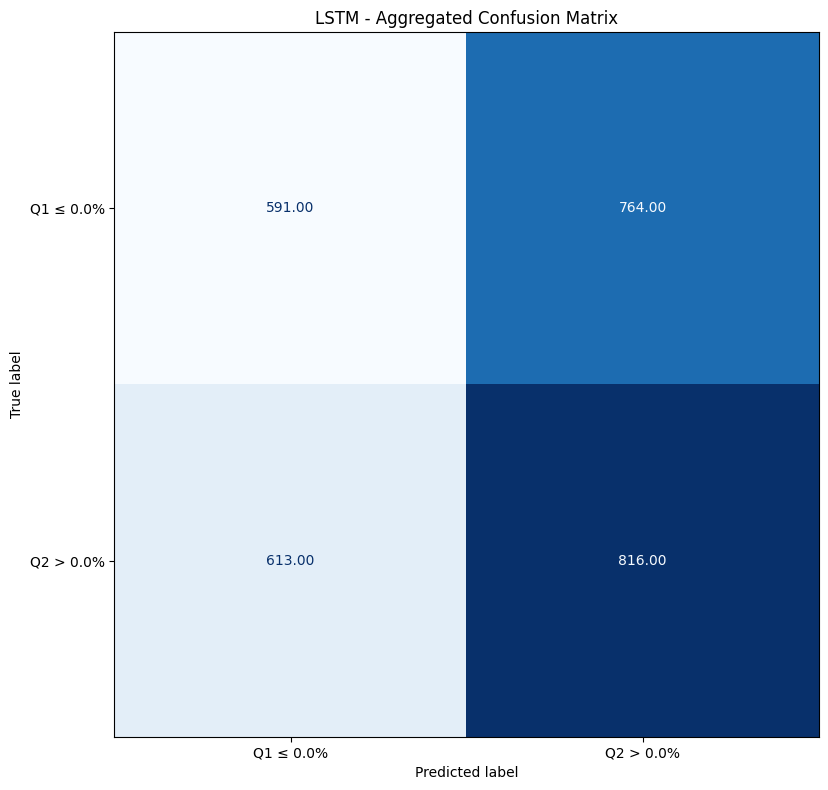

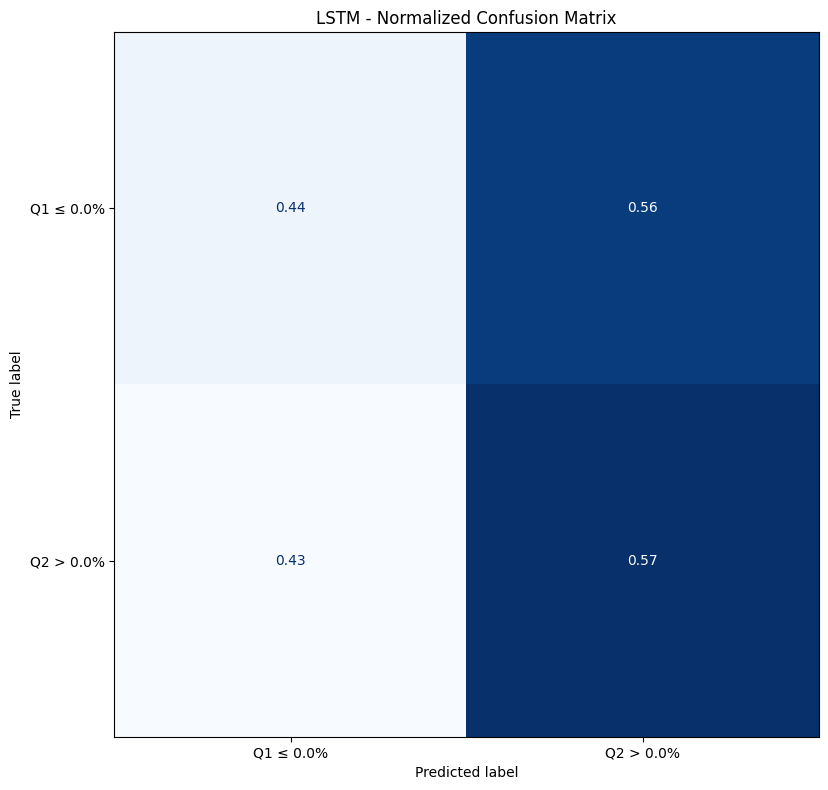

Loss curves saved to results/benchmarking/classification/LSTM_loss_curves.csv

STOCK PREDICTION PIPELINE RESULTS
Model: LSTM | Problem: classification
Companies analyzed: 50
Average samples per company: 320

OVERALL PERFORMANCE
Directional Accuracy:   0.5049 (±0.0642)
Matthews Correlation:   0.0507 (±0.1082)
F1 Score:              0.4510 (±0.2652)
Precision:             0.4284 (±0.2549)
Recall:                0.5765 (±0.3967)

PERFORMANCE BY SECTOR
Consumer Goods       | Acc: 0.531±0.049 | MCC: 0.114 | Companies: 5
Utilities            | Acc: 0.526±0.092 | MCC: 0.131 | Companies: 2
Healthcare           | Acc: 0.525±0.042 | MCC: 0.035 | Companies: 9
Industrial Goods     | Acc: 0.509±0.107 | MCC: 0.056 | Companies: 6
Financial            | Acc: 0.498±0.083 | MCC: 0.053 | Companies: 6
Basic Matierials     | Acc: 0.497±0.049 | MCC: 0.024 | Companies: 5
Technology           | Acc: 0.492±0.049 | MCC: 0.020 | Companies: 8
Services             | Acc: 0.483±0.068 | MCC: 0.051 | Companies: 9

TO

,company,sector,model_type,problem_type,horizon_steps,macro_f1,micro_accuracy,expected_return_mean,mse,mae,...,precision,recall,directional_accuracy,n_samples,train_samples,val_samples,test_samples,epochs_trained,confusion_matrix,confusion_matrix_normalized
0,AAPL,Consumer Goods,LSTM,classification,1,NaN,NaN,NaN,NaN,NaN,...,0.491803,0.857143,0.538462,468,312,78,78,19,"[[12, 31], [5, 30]]","[[0.27906976744186046, 0.7209302325581395], [0..."
1,ABBV,Healthcare,LSTM,classification,1,NaN,NaN,NaN,NaN,NaN,...,0.553191,1.000000,0.553191,283,189,47,47,22,"[[0, 21], [0, 26]]","[[0.0, 1.0], [0.0, 1.0]]"
2,AMGN,Healthcare,LSTM,classification,1,NaN,NaN,NaN,NaN,NaN,...,0.650000,0.500000,0.583333,293,196,49,48,23,"[[15, 7], [13, 13]]","[[0.6818181818181818, 0.3181818181818182], [0...."
3,AMZN,Services,LSTM,classification,1,NaN,NaN,NaN,NaN,NaN,...,0.523810,0.268293,0.473684,458,306,76,76,16,"[[25, 10], [30, 11]]","[[0.7142857142857143, 0.2857142857142857], [0...."
4,BA,Industrial Goods,LSTM,classification,1,NaN,NaN,NaN,NaN,NaN,...,0.750000,0.535714,0.653846,315,211,52,52,22,"[[19, 5], [13, 15]]","[[0.7916666666666666, 0.20833333333333334], [0..."


In [14]:

print(f"\n{'='*25}\n  RUNNING PIPELINE FOR: LSTM\n{'='*25}\n")

pipeline_LSTM = StockPredictionPipeline(
    df=master_df,
    feature_columns=feature_columns,
    model_type='LSTM',
    sequence_length=sequence_length,
    problem_type='classification',
    horizon_steps=1
)

results_LSTM = pipeline_LSTM.run_pipeline()

# Only plot confusion matrices for classification/multiclass problems
if pipeline_LSTM.problem_type == 'multiclass':
    agg_cm, q_labels, interval_labels, display_labels = aggregate_confusions_with_median_edges(results_LSTM, n_classes=6)
elif pipeline_LSTM.problem_type == 'classification':
    agg_cm, q_labels, interval_labels, display_labels = aggregate_confusions_with_median_edges(results_LSTM, n_classes=2)

if pipeline_LSTM.problem_type in ['classification', 'multiclass'] and agg_cm is not None:
    plot_confusion(agg_cm, display_labels, title="LSTM - Aggregated Confusion Matrix")
    agg_norm = agg_cm / np.clip(agg_cm.sum(axis=1, keepdims=True), 1, None)
    plot_confusion(agg_norm, display_labels, title="LSTM - Normalized Confusion Matrix")
    
loss_df = pipeline_LSTM.get_loss_curves_df()

pipeline_LSTM.save_loss_curves('results/benchmarking/')

if results_LSTM is not None and not results_LSTM.empty:
    analysis_LSTM = pipeline_LSTM.analyze_results()
    pipeline_LSTM.save_results(results_LSTM, output_dir='results/benchmarking/')

    all_pipelines["LSTM"] = pipeline_LSTM
    all_results_dfs["LSTM"] = results_LSTM
    all_analyses["LSTM"] = analysis_LSTM

    print("\nDisplaying first 5 rows of LSTM results:")
    display(results_LSTM.head())
else:
    print(f"\n[FAILED] Pipeline for LSTM did not produce any results.")

del pipeline_LSTM

,count,fraction
bucket,,
≤ -15%,6,0.0001
"(-15,-8]%",58,0.0006
"(-8,0]%",50343,0.4835
"(0,8]%",53628,0.5150
"(8,15]%",87,0.0008
≥ 15%,10,0.0001


/var/folders/jx/mdk91y8925ncdd32prjkcl_c0000gn/T/ipykernel_66097/151732707.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['date','bucket'])


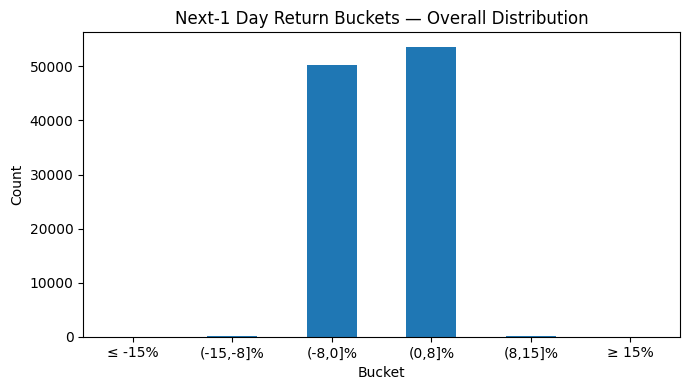

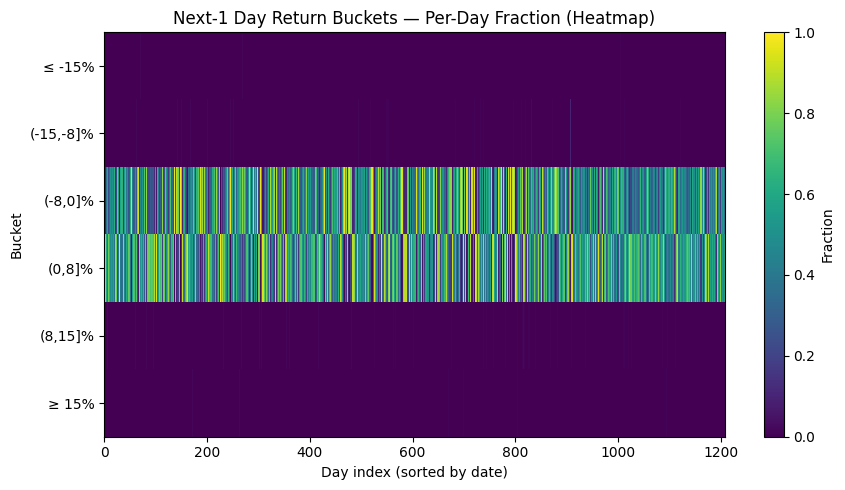

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

H = 1  # horizon in days
BINS = [-np.inf, -0.15, -0.08, 0.0, 0.08, 0.15, np.inf]  # ≤-15, -15..-8, -8..0, 0..8, 8..15, ≥15
LABELS = ["≤ -15%", "(-15,-8]%", "(-8,0]%", "(0,8]%", "(8,15]%", "≥ 15%"]

price_col = 'close_price' if 'close_price' in master_df.columns else 'close'
assert {'date','ticker',price_col}.issubset(master_df.columns), "master_df missing required columns."

df = master_df[['date','ticker',price_col]].copy()
df = df.sort_values(['ticker','date'])

# Forward return over H days: r_{t→t+H} = P_{t+H}/P_t - 1
df['ret_fwd'] = df.groupby('ticker')[price_col].transform(lambda s: s.shift(-H) / s - 1.0)

# Bucketise
df['bucket'] = pd.cut(df['ret_fwd'], bins=BINS, labels=LABELS, include_lowest=True, right=True)

#overall distribution (all tickers, all days)
overall_counts = df['bucket'].value_counts(dropna=True).reindex(LABELS).fillna(0).astype(int)
overall_frac = (overall_counts / overall_counts.sum()).round(4)
display(pd.DataFrame({'count': overall_counts, 'fraction': overall_frac}))

#Per-day distribution (counts)
per_day = (df.dropna(subset=['bucket'])
             .groupby(['date','bucket'])
             .size()
             .unstack(fill_value=0)
             .reindex(columns=LABELS)
          )

plt.figure(figsize=(7,4))
overall_counts.plot(kind='bar')
plt.title(f"Next-{H} Day Return Buckets — Overall Distribution")
plt.ylabel("Count")
plt.xlabel("Bucket")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

per_day_frac = per_day.div(per_day.sum(axis=1), axis=0).fillna(0)

plt.figure(figsize=(9,5))
plt.imshow(per_day_frac.T, aspect='auto', interpolation='nearest')
plt.title(f"Next-{H} Day Return Buckets — Per-Day Fraction (Heatmap)")
plt.yticks(range(len(LABELS)), LABELS)
plt.xlabel("Day index (sorted by date)")
plt.ylabel("Bucket")
plt.colorbar(label="Fraction")
plt.tight_layout()
plt.show()
